# Author: Tim Harmling and Alexej Kravtschenko
- **Note:** This notebook was written by the combined effort of Tim Harmling and Alexej Kravtschenko 
- **Description:** With this notebook you can train your own handwriting model form scratch or use an existing model for transfer learning

## Imports

In [1]:
# Unsere Klassen
import load_data as load_data
import models
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import time
import os
import re

2024-05-05 13:42:56.771165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 13:42:56.771199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 13:42:56.771752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 13:42:56.774957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 13:42:57.230040: W tensorflow/compiler/tf2

## Config

In [2]:
from config import *

## Load Data

In [3]:
load_data.print_samples(DATA_BASE_PATH)
x_train_img_paths, y_train_labels = load_data.get_train_data()
x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()

Total train samples: 10209
Total validation samples: 567
Total test samples: 568
Maximum length:  93
Vocab size:  79


In [4]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['../dataset/iam_dataset/lines/m06/m06-106/m06-106-03.png', '../dataset/iam_dataset/lines/a01/a01-132u/a01-132u-03.png'] ['and|Haris|there|were|many|events|.|Chief|of|these|was', 'adjust|the|financing|-|which|Mr.|Powell']
Validation path: ['../dataset/iam_dataset/lines/b04/b04-034/b04-034-04.png', '../dataset/iam_dataset/lines/a05/a05-004/a05-004-05.png'] ['Newmarket|urban|council|,|says|:|"|I|shall|always|feel|this|as|a', 'and|operations|.|This|would|apply|also|in|the']
Testing path: ['../dataset/iam_dataset/lines/a02/a02-093/a02-093-01.png', '../dataset/iam_dataset/lines/n02/n02-049/n02-049-03.png'] ['priority|to|the|clash|over|Northern|Rhodesia|on|his', 'look|as|though|it|was|only|what|you|expected|of|me|,']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)

60_8
71_5
10_6
8_3
14_11
22_12
12_6
10_11
61_4
52_6
27_2
26_16
75_7
13_15
34_4
38_7
61_2
48_9
62_3
56_4
46_5
50_8
71_4
20_12
74_7
7_2
25_4
62_5
56_6
33_4
10_7
45_1
30_1
4_5
24_16
21_11
11_0
24_5
71_7
30_8
21_7
44_3
49_6
70_3
42_10
12_9
26_1
41_4
57_8
20_7
4_8
3_4
16_8
71_6
35_2
36_2
75_3
6_6
28_8
4_4
55_8
4_7
27_4
12_10
22_8
10_9
68_0
4_0
29_4
42_3
33_6
37_5
17_13
16_12
20_4
25_5
52_8
32_2
13_8
55_3
12_7
32_4
20_11
43_8
26_0
12_14
19_2
29_7
50_9
33_5
17_14
17_0
39_7
53_11
18_8
29_0
19_0
23_8
36_3
31_1
46_4
75_8
2_6
43_5
10_8
14_5
10_10
23_4
8_5
55_5
18_7
37_0
71_3
49_5
26_4
7_3
19_12
5_0
11_11
44_6
49_8
3_8
37_3
67_8
9_12
27_1
19_10
44_5
71_8
28_5
36_1
65_3
9_14
23_3
21_5
24_2
31_6
8_1
41_9
67_6
32_1
25_2
63_3
26_2
13_2
61_6
31_7
13_12
22_9
7_4
9_10
43_9
40_9
39_4
40_7
7_6
40_6
64_3
11_13
54_4
42_1
42_0
28_4
35_3
49_4
21_12
21_4
34_3
27_3
10_5
30_5
5_16
74_9
56_2
38_3
55_0
54_6
22_7
60_3
21_8
9_9
60_2
4_1
2_2
5_4
2_8
8_8
26_3
7_1
57_6
69_8
29_5
18_6
51_5
27_5
12_15
52_5
8_4
9_7
3_2
40_

## Show Examples

2024-05-05 13:42:59.075784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


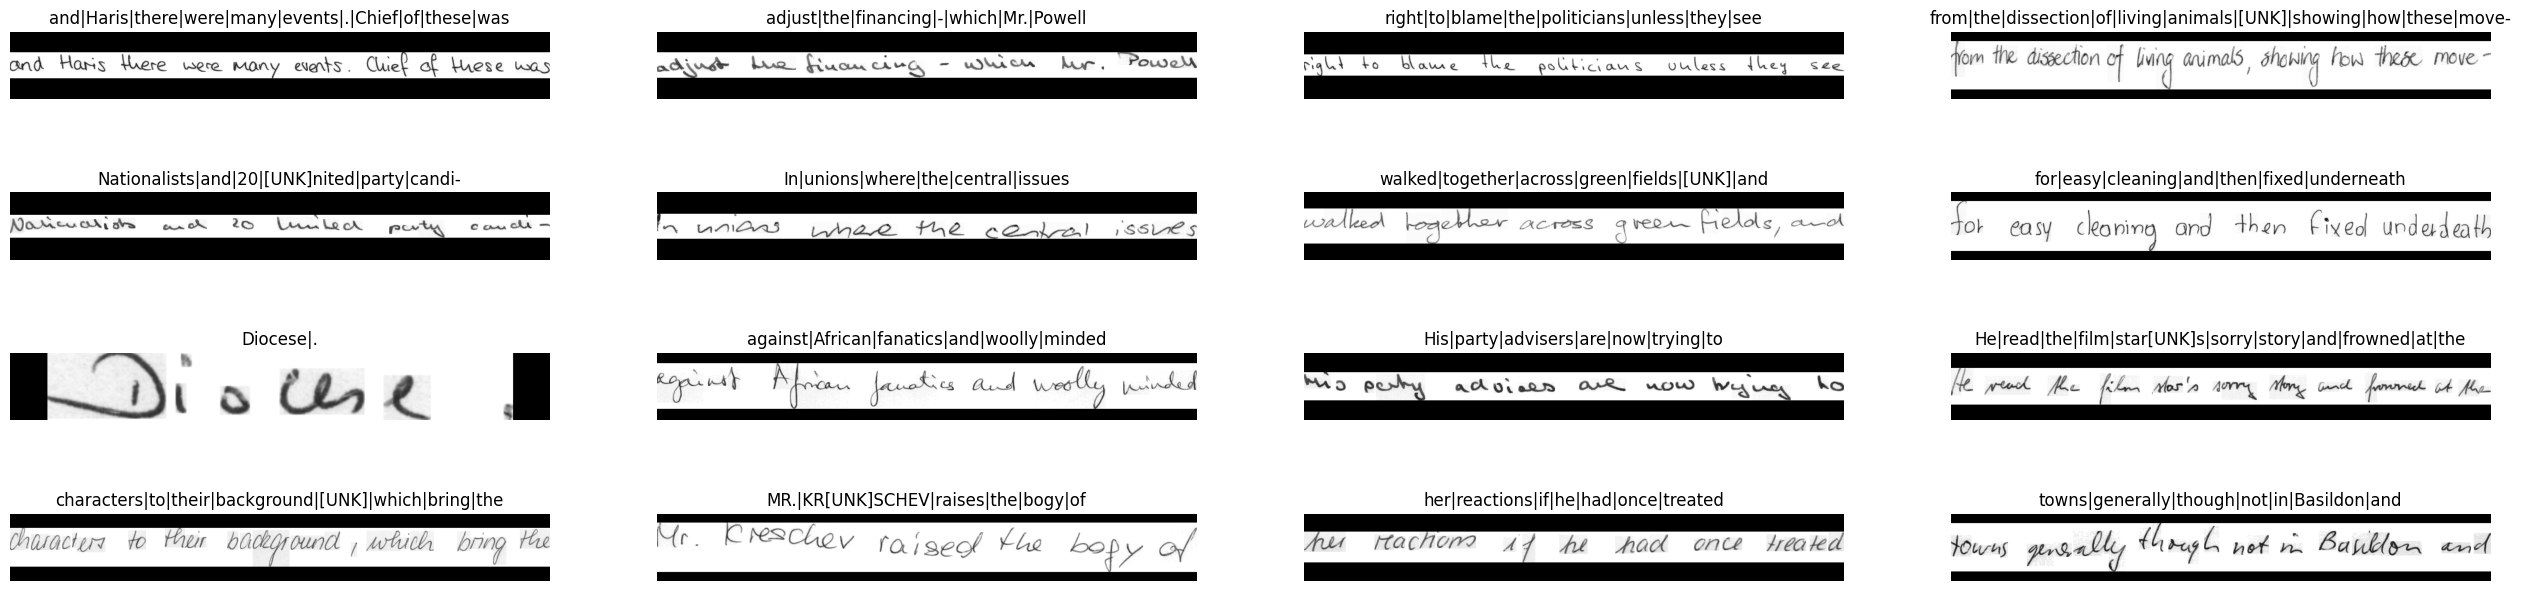

In [6]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(BATCH_SIZE):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# Train Keras Model

In [7]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    """Loads model weights if they exist.

    This function checks if the model weights exist and loads them into the model.

    Args:
        model: The Keras model.

    Returns:
        None
    """
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [8]:
def train_model(model):
    """Trains the model and returns prediction model and training history.

    This function trains the provided model using the training and validation datasets.
    It also returns a prediction model and training history.

    Args:
        model: The Keras model to be trained.

    Returns:
        prediction_model: The model used for predictions.
        history: The training history.
    """
    #model_load_weights_if_exists(model) # Uncomment this line for transfer learning
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE, min_lr=1e-6, verbose=1)
    history = model.fit(aug_train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[reduce_lr, early_stopping])    
    return prediction_model, history

In [9]:
char = len(tokenizer.char_to_num.get_vocabulary())
model = models.build_model9v3(IMAGE_WIDTH, IMAGE_HEIGHT, char, LEARNING_RATE)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 1024, 128, 1)]       0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 1024, 128, 48)        480       ['image[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 1024, 128, 96)        41568     ['Conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 512, 64, 96)          0         ['Conv2[0][0]']               
                                                                             

In [10]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/100


2024-05-05 13:43:03.640081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inhandwriting_recognizer/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-05 13:43:03.960618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-05 13:43:04.196786: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-05 13:43:04.664890: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory

141/639 [=====>........................] - ETA: 3:06 - loss: 209.8819

KeyboardInterrupt: 

# Plot helper functions


In [ ]:
def plot_history(history, name, dir_path, save_fig):
    """Plots the training history of a model.
    
    This function takes the training history of a model and plots the training and validation loss
    across epochs. It also plots the learning rate on a secondary y-axis using a logarithmic scale.

    Args:
        history: The training history of the model.
        name (str): The name of the model.
        dir_path (str): The directory path to save the plot.
        save_fig (bool): A flag indicating whether to save the plot as an image.

    Returns:
        None
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [ ]:
# Creates a directory if it doesn't exist
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(BATCH_SIZE):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

In [ ]:
def create_new_plot_name(model_name, names, format):
    
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    
    return format.replace(model_name,new_model_name)

# Model Testing

In [ ]:
""" Author: Alexej Kravtschenko (main) and Tim Harmling (wrote)
    
Creates a new plot name based on existing names.
This function generates a new plot name by appending a version number to the given model name.
The version number is determined based on existing plot names in the directory.

Args:
    model_name (str): The base model name.
    names (list): A list of existing plot names.
    format (str): The format string for the plot name.

Returns:
    str: The new plot name.
"""
     
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [ ]:
# Saves the model after training if MODEL_SAVE = True
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)

    data_to_save = (load_data.max_len, load_data.characters)
    import pickle
    with open(os.path.join(model_path, "handwriting_chars.pkl"), 'wb') as file:
        pickle.dump(data_to_save, file)